# Poc utilizando KNN para trabalho de conclusão de Ciência da computação da Feevale
## Carrega JSON

In [1]:
import json

users = {}

with open('spotify-plugin-app-export.json') as json_file:
    data = json.load(json_file)

    for userKey in data['events'].keys():
        user = data['events'][userKey]
        userEvents = []

        for key in user.keys():
            userEvents.append(user[key])

        users[userKey] = userEvents


for userKey in users.keys():
    print(f"len({userKey}) => {len(users[userKey])}")

len(spotify:user:16nxkn6lmlix2ou2w2rvodu3n) => 9
len(spotify:user:226rxsqefx3heakyeln7t3unq) => 27
len(spotify:user:22iwjt6kc4zv74sq7cutkhtwy) => 9
len(spotify:user:3152wu7mz2aoxfrg5mtqov77lseu) => 19
len(spotify:user:31bfdxg5fe2335adqfcg4xpugpcq) => 10
len(spotify:user:3ka2awymoso1wgdlwuq50uz8h) => 16
len(spotify:user:4i3jdhv6vubcjdpwsn38iv8u4) => 376
len(spotify:user:8q3uk0rwypu5r7dsq48476qak) => 5
len(spotify:user:andressltz) => 162
len(spotify:user:b8r2mhyhep5t0np1keaqmvvi0) => 20
len(spotify:user:gabrielcartelli) => 3
len(spotify:user:ggkonzen) => 12
len(spotify:user:iisa1999) => 326
len(spotify:user:iortim) => 174
len(spotify:user:jyangalonga) => 229
len(spotify:user:maiconunzer) => 7
len(spotify:user:o16tnkq56zdt2obwii1vgbs4o) => 5
len(spotify:user:tiagoterme) => 65


## Separa Contexto

In [2]:
import pandas as pd

usersContexts = {}

contexts = []
currentCtx = None

for event in users['spotify:user:4i3jdhv6vubcjdpwsn38iv8u4']:
    if event['action'] == "CHOOSE_FEELING":
        if currentCtx:
            contexts.append(currentCtx)

        currentCtx = {"musics": [], "info": {"feeling": event['value']}}
    elif event['action'] == "CHOOSE_ACTIVITY":
        currentCtx['info']['activity'] = event['value']
    elif event['action'] == "CHOOSE_LOCATION":
        currentCtx['info']['location'] = event['value']
    elif event['action'] == "LOAD_LOCATION":
        # currentCtx['info']['loaded_location'] = event['value']
        a = 0
    else:
        currentCtx['musics'].append(event)

contexts.append(currentCtx)

df=pd.DataFrame(contexts)

df.head()

musics  \
0  [{'action': 'PLAY_MUSIC', 'createdDateTime': '...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

                                                info  
0  {'feeling': 'feliz;alegre', 'activity': 'estud...  
1  {'feeling': 'feliz', 'activity': 'estudando', ...  
2  {'feeling': 'alegre', 'activity': 'estudando',...  
3  {'feeling': 'feliz', 'activity': 'estudando', ...  
4  {'feeling': 'alegre;animada', 'activity': 'est...

## Separa contexto das musicas

In [3]:
musicTable = []
currentMusicCtx = None
lastMusic = None

for ctx in contexts:
    for music in ctx['musics']:
        if music['value'] != lastMusic:
            if lastMusic:
                currentMusicCtx.update(ctx['info'])
                musicTable.append(currentMusicCtx)
            
            lastMusic = music['value']
            currentMusicCtx = {'uri': music['value'], 'like': 0, 'hate':0, 'restart':0}

        if music['action'] == 'LIKED_MUSIC':
            currentMusicCtx['like'] += 1
        elif music['action'] == 'HATED_MUSIC':
            currentMusicCtx['hate'] += 1
        elif music['action'] == 'RESTART_MUSIC':
            currentMusicCtx['restart'] += 1

    currentMusicCtx.update(ctx['info'])
    musicTable.append(currentMusicCtx)


dfm=pd.DataFrame(musicTable)

dfm.head()

uri  like  hate  restart       feeling  \
0  spotify:track:29aSfWddeZJCfnrcMb20sy     1     0        0  feliz;alegre   
1  spotify:track:2evFJQfQVcDEXyOiyEV6OW     0     0        0  feliz;alegre   
2  spotify:track:6Te1vrlCz4DdCeONagkT6j     0     0        1  feliz;alegre   
3  spotify:track:5YrMcUZoNXlUCfwgnfocgL     0     0        0  feliz;alegre   
4  spotify:track:120w1eBYfiYrSXtegu6uEb     1     0        0  feliz;alegre   

    activity location  
0  estudando     casa  
1  estudando     casa  
2  estudando     casa  
3  estudando     casa  
4  estudando     casa

## busca informações das musicas

In [4]:
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv # add this line

load_dotenv() # add this line

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=os.getenv('SPOTIFY_CLIENT_ID'),
                                                           client_secret=os.getenv('SPOTIFY_CLIENT_SECRET')))

musicsIds = list(map(lambda x : x['uri'], musicTable))

tracks = []
tracksMap = {}

i = 0

while i < len(musicsIds):
    ids = musicsIds[i:i + 50]
    response = sp.tracks(ids)
    tracks.extend(response['tracks'])
    i += 50

for track in tracks:
    tracksMap[track['uri']] = track

dft=pd.DataFrame(tracksMap)

dft

False   
name                                                 Best I Ever Had   
popularity                                                        52   
preview_url                                                     None   
track_number                                                       2   
type                                                           track   
uri                             spotify:track:120w1eBYfiYrSXtegu6uEb   

                                spotify:track:03nPEoQOYMuDe7KmGljpmd  \
album              {'album_type': 'album', 'artists': [{'external...   
artists            [{'external_urls': {'spotify': 'https://open.s...   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   260000   
explicit                                                        True   
external_ids                                {'isrc': 'USSM11806283'}   
external_urls      {'spotify': 'https://open.spotify.com/track/03...   
href               https://api.spotify.com/v1/tracks/03nPEoQOYMuD...   
id                                            03nPEoQOYMuDe7KmGljpmd   
is_local                                                       False   
name               No Brainer (feat. Justin Bieber, Chance the Ra...   
popularity                                                        66   
preview_url        https://p.scdn.co/mp3-preview/607449ba733224db...   
track_number                                                      13   
type                                                           track   
uri                             spotify:track:03nPEoQOYMuDe7KmGljpmd   

                                spotify:track:6PYnUsNEpYC7A4BS2sjw3L  \
album              {'album_type': 'single', 'artists': [{'externa...   
artists            [{'external_urls': {'spotify': 'https://open.s...   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   254999   
explicit                                                       False   
external_ids                                {'isrc': 'USRC11902029'}   
external_urls      {'spotify': 'https://open.spotify.com/track/6P...   
href               https://api.spotify.com/v1/tracks/6PYnUsNEpYC7...   
id                                            6PYnUsNEpYC7A4BS2sjw3L   
is_local                                                       False   
name                       Right Back (feat. A Boogie Wit Da Hoodie)   
popularity                                                        69   
preview_url        https://p.scdn.co/mp3-preview/276028634b0fdea7...   
track_number                                                       1   
type                                                           track   
uri                             spotify:track:6PYnUsNEpYC7A4BS2sjw3L   

                                spotify:track:50UkypyQJbSQLaXHke5Yep  \
album              {'album_type': 'album', 'artists': [{'external...   
artists            [{'external_urls': {'spotify': 'https://open.s...   
available_markets  [AD, AR, AT, AU, BA, BE, BG, BO, BR, CA, CH, C...   
disc_number                                                        1   
duration_ms                                                   180493   
explicit                                                        True   
external_ids                                {'isrc': 'USUM70503011'}   
external_urls      {'spotify': 'https://open.spotify.com/track/50...   
href               https://api.spotify.com/v1/tracks/50UkypyQJbSQ...   
id                                            50UkypyQJbSQLaXHke5Yep   
is_local                                                       False   
name                                  There It Go (The Whistle Song)   
popularity                  

## busca informações dos artistas (genero)

In [5]:
artistsIds = list(map(lambda x : x['artists'][0]['id'], tracks))

artists = []
artistsMap = {}

i = 0
while i < len(artistsIds):
    ids = artistsIds[i:i + 50]
    response = sp.artists(ids)
    artists.extend(response['artists'])
    i += 50

for artist in artists:
    artistsMap[artist['uri']] = artist

dfa=pd.DataFrame(artistsMap)

dfa

spotify:artist:2IvkS5MXK0vPGnwyJsrEyV  \
external_urls  {'spotify': 'https://open.spotify.com/artist/2...   
followers                       {'href': None, 'total': 2729649}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/2IvkS5MXK0v...   
id                                        2IvkS5MXK0vPGnwyJsrEyV   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                                 Eric Church   
popularity                                                    77   
type                                                      artist   
uri                        spotify:artist:2IvkS5MXK0vPGnwyJsrEyV   

                           spotify:artist:3THMgU4KdL7LlO5TEREs2g  \
external_urls  {'spotify': 'https://open.spotify.com/artist/3...   
followers                        {'href': None, 'total': 435831}   
genres         [country, country road, country rock, oklahoma...   
href           https://api.spotify.com/v1/artists/3THMgU4KdL7...   
id                                        3THMgU4KdL7LlO5TEREs2g   
images         [{'height': 1500, 'url': 'https://i.scdn.co/im...   
name                                                  Joe Diffie   
popularity                                                    64   
type                                                      artist   
uri                        spotify:artist:3THMgU4KdL7LlO5TEREs2g   

                           spotify:artist:6yJCxee7QumYr820xdIsjo  \
external_urls  {'spotify': 'https://open.spotify.com/artist/6...   
followers                       {'href': None, 'total': 2358593}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/6yJCxee7Qum...   
id                                        6yJCxee7QumYr820xdIsjo   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                              Zac Brown Band   
popularity                                                    77   
type                                                      artist   
uri                        spotify:artist:6yJCxee7QumYr820xdIsjo   

                           spotify:artist:37W8SKV5Vc8lcGtdyWCA5m  \
external_urls  {'spotify': 'https://open.spotify.com/artist/3...   
followers                        {'href': None, 'total': 738874}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/37W8SKV5Vc8...   
id                                        37W8SKV5Vc8lcGtdyWCA5m   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                                  Gary Allan   
popularity                                                    62   
type                                                      artist   
uri                        spotify:artist:37W8SKV5Vc8lcGtdyWCA5m   

                           spotify:artist:0QHgL1lAIqAw0HtD7YldmP  \
external_urls  {'spotify': 'https://open.spotify.com/artist/0...   
followers                       {'href': None, 'total': 5226876}   
genres         [dance pop, hip hop, miami hip hop, pop, pop r...   
href           https://api.spotify.com/v1/artists/0QHgL1lAIqA...   
id                                        0QHgL1lAIqAw0HtD7YldmP   
images         [{'height': 640, 'url': 'https://i.scdn.co/ima...   
name                                                   DJ Khaled   
popularity                                                    86   
type                                                      artist   
uri                        spotify:artist:0QHgL1lAIqAw0HtD7YldmP   

                           spotify:artist:6LuN9FCkKOj5PcnpouEgny  \
external_urls  {'spotify': 'https://open.spotify.com/artist/6...   
followers                      {'href': None, 'total': 12734140}   
genres                                    [alternative r&b, pop]   
href      

## adiciona genero a tabela

In [6]:
for music in musicTable:
    artistId = tracksMap[music['uri']]['artists'][0]['uri']

    music['genre'] = artistsMap[artistId]['genres']

dfmg=pd.DataFrame(musicTable)

dfmg.head()

uri  like  hate  restart       feeling  \
0  spotify:track:29aSfWddeZJCfnrcMb20sy     1     0        0  feliz;alegre   
1  spotify:track:2evFJQfQVcDEXyOiyEV6OW     0     0        0  feliz;alegre   
2  spotify:track:6Te1vrlCz4DdCeONagkT6j     0     0        1  feliz;alegre   
3  spotify:track:5YrMcUZoNXlUCfwgnfocgL     0     0        0  feliz;alegre   
4  spotify:track:120w1eBYfiYrSXtegu6uEb     1     0        0  feliz;alegre   

    activity location                                              genre  
0  estudando     casa  [contemporary country, country, country road, ...  
1  estudando     casa  [country, country road, country rock, oklahoma...  
2  estudando     casa  [contemporary country, country, country road, ...  
3  estudando     casa  [contemporary country, country, country road, ...  
4  estudando     casa  [contemporary country, country, country road, ...

## trocar musica por genero

In [7]:
genreTable = []

for music in musicTable:
    for genre in music['genre']:
        newGenre = music.copy()

        del newGenre['uri']
        del newGenre['genre']

        newGenre['genre'] = genre

        genreTable.append(newGenre)

dfg=pd.DataFrame(genreTable)

dfg.head()

like  hate  restart       feeling   activity location                 genre
0     1     0        0  feliz;alegre  estudando     casa  contemporary country
1     1     0        0  feliz;alegre  estudando     casa               country
2     1     0        0  feliz;alegre  estudando     casa          country road
3     1     0        0  feliz;alegre  estudando     casa   modern country rock
4     0     0        0  feliz;alegre  estudando     casa               country

## Trata contextos duplicados (;)

In [8]:
def trataMultiplosDaColuna(key):
    print(f"before {key} len({len(genreTable)})")

    i = 0

    while i < len(genreTable):
        genre = genreTable[i]
        ctxSplit = genre[key].split(";")
        genreTable.pop(i)

        for ctx in ctxSplit:
            genreCopy = genre.copy()
            genreCopy[key] = ctx
            genreTable.insert(i, genreCopy)

        i += 1

    print(f"after {key} len({len(genreTable)})")


trataMultiplosDaColuna("feeling") 
trataMultiplosDaColuna("activity")
trataMultiplosDaColuna("location")

before feeling len(489)
after feeling len(845)
before activity len(845)
after activity len(1147)
before location len(1147)
after location len(1147)


## Trata contextos musicais (multiplos like, hate, restart)

In [9]:
def trataNumericosDaColuna(key):
    print(f"before {key} len({len(genreTable)})")

    i = 0

    while i < len(genreTable):
        genre = genreTable[i]
        
        if genre[key] > 0:
            genreTable.pop(i)

            j = 0

            while j < genre[key]:
                genreCopy = genre.copy()
                genreCopy[key] = 1
                genreTable.insert(i, genreCopy)

                j += 1

        i += 1

    print(f"after {key} len({len(genreTable)})")


trataNumericosDaColuna("like") 
trataNumericosDaColuna("hate")
trataNumericosDaColuna("restart")

dfg=pd.DataFrame(genreTable)

dfg.head()

before like len(1147)
after like len(1447)
before hate len(1447)
after hate len(1471)
before restart len(1471)
after restart len(1471)


like  hate  restart feeling   activity location                 genre
0     1     0        0  alegre  estudando     casa  contemporary country
1     1     0        0   feliz  estudando     casa  contemporary country
2     1     0        0  alegre  estudando     casa               country
3     1     0        0   feliz  estudando     casa               country
4     1     0        0  alegre  estudando     casa          country road

## transformar labels

In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

dfg['feeling'] = le.fit_transform(dfg['feeling'])
dfg['activity'] = le.fit_transform(dfg['activity'])
dfg['location'] = le.fit_transform(dfg['location'])

dfg.head()

like  hate  restart  feeling  activity  location                 genre
0     1     0        0        1         2         1  contemporary country
1     1     0        0        8         2         1  contemporary country
2     1     0        0        1         2         1               country
3     1     0        0        8         2         1               country
4     1     0        0        1         2         1          country road

## plotar

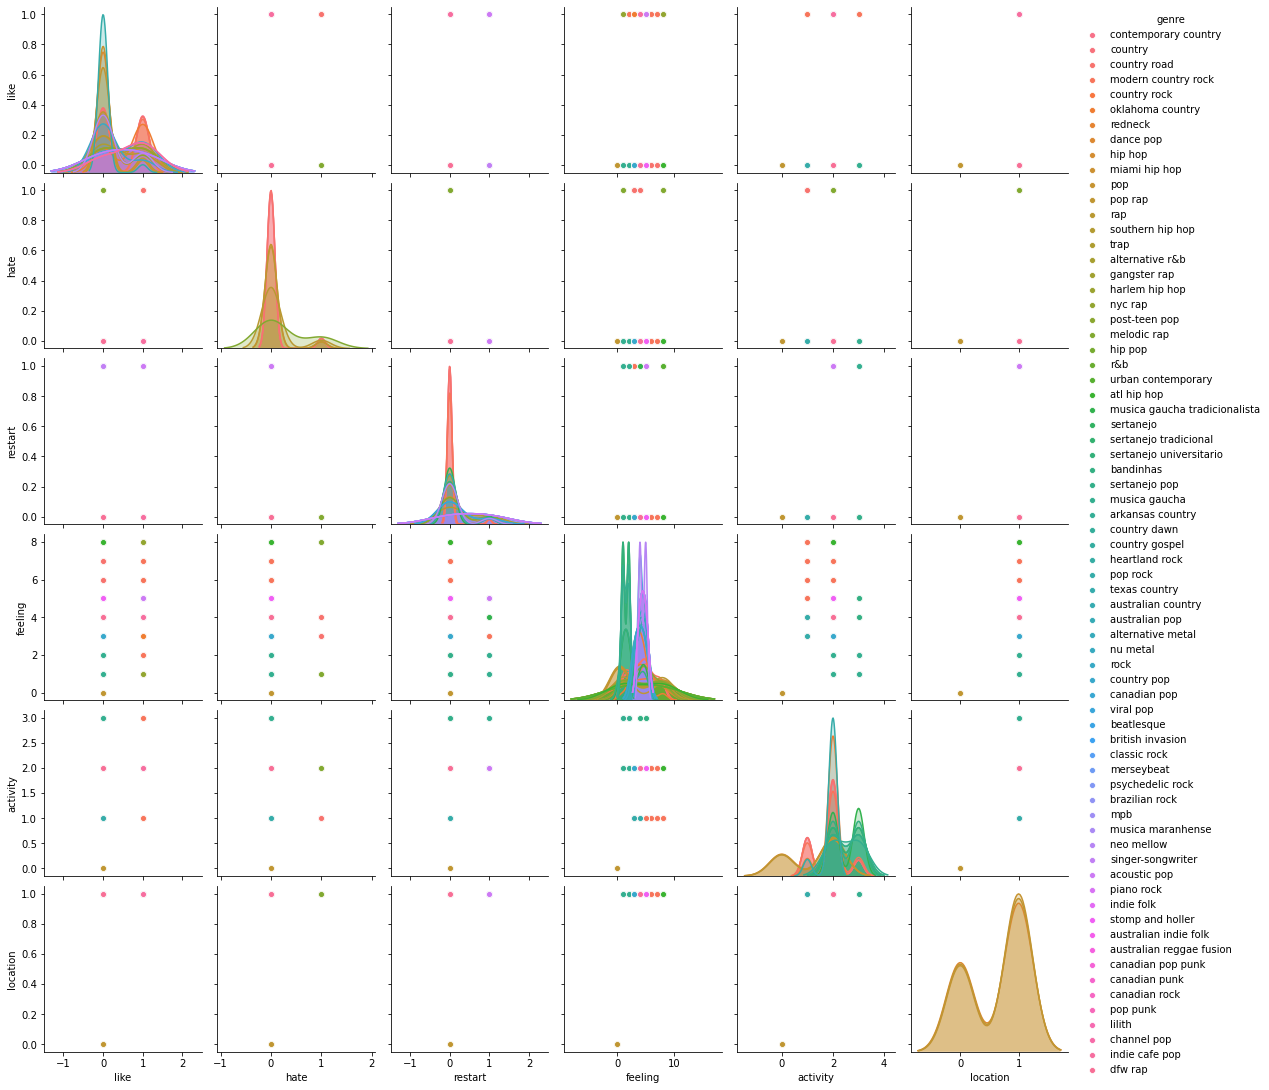

In [11]:
import seaborn as sns

sns.pairplot(dfg, hue="genre")

## knn 

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

model = KNeighborsClassifier(n_neighbors=3)

dfgCopy = dfg.copy()

del dfgCopy['genre']

labels = le.fit_transform(dfg['genre'])

X = dfgCopy[dfgCopy.columns[:]]
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

model.fit(X_train, y_train)

print(X_test)

result = model.predict(X_test)

print(result)

# print(dfg['genre'][result-1])

      like  hate  restart  feeling  activity  location
431      0     0        0        1         2         1
861      1     0        0        8         1         1
237      0     0        0        2         2         1
1056     1     0        0        3         2         1
636      0     0        0        5         2         1
...    ...   ...      ...      ...       ...       ...
262      0     0        0        1         3         1
164      0     0        0        1         2         1
274      0     0        0        1         3         1
1085     0     0        0        4         2         1
592      0     0        0        5         2         1

[442 rows x 6 columns]
[19 19 20 20 19 19 26 19 19 26 20 19 19 20 51 24 20 39 20 19 20 20 19 20
 20 26 19 19 20 19 19 20 19 19 20 19 39 20 20 20 19 19 19 19 18 20 19 20
 20 19 39 19 19 20 19 20 19 20 20 19 19 19 19 20 20 20 19 18 20 19 20 19
 19 19 20 19 42 39 39 39 19 20 20 19 19 20 39 20 19 20 19 20 20 42 20 20
 20  9 20 20 19 19 19 20

## Score KNN

In [13]:
model.score(X_test, y_test)

0.1583710407239819